In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Deep Learning Challenge

Mounted at /gdrive
/gdrive/My Drive/Deep Learning Challenge


In [2]:
from google.colab import files

!rm -rf models.py
!rm -rf visualization.py
!rm -rf data_preparation.py
files.upload()

Saving data_preparation.py to data_preparation.py
Saving visualization.py to visualization.py


{'data_preparation.py': b'# Import tensorflow\r\nimport tensorflow as tf\r\nfrom tensorflow import keras as tfk\r\nfrom tensorflow.keras import layers as tfkl\r\nimport matplotlib.pyplot as plt\r\nimport numpy as np\r\nfrom random import randint\r\nfrom sklearn.preprocessing import LabelEncoder\r\n\r\n\r\ndef process_sample(img, process=True):\r\n    # Normalize image pixel values to a float range [0, 1]\r\n    img = (img / 255).astype(np.float32)\r\n\r\n    if (process):\r\n      # Convert image from BGR to RGB\r\n      img = img[...,::-1]\r\n      # Make the image dataset squared\r\n      dim = min(img.shape[:-1])\r\n      img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]\r\n\r\n      # Resize the image to 224x224 pixels\r\n      #img = tfkl.Resizing(224, 224)(img)\r\n      #img = tfkl.Resizing(96, 96)(img)\r\n\r\n    return img\r\n\r\ndef load_data(folder="public_data.npz", resolution=96, head_only=False, process=True):\r\n    ima

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from data_preparation import load_data, delete_outliers
import numpy as np
from visualization import plot_history
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import random
import cv2
import os

X, y = load_data()

X, y, num_outliers = delete_outliers(X, y)

# Split data into train_val and test sets
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y)

print(X_train.shape)
print(X_val.shape)
#print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))

(4503, 96, 96, 3)
(501, 96, 96, 3)
(array([0, 1]), array([2791, 1712]))
(array([0, 1]), array([310, 191]))


In [4]:
def explore_augmentation(augmentation, X, num_images=10):
  X_augmented = augmentation(X)

  fig, axes = plt.subplots(2, num_images, figsize=(20,4))
  for i in range(num_images):
      index = random.randint(0, len(X))
      ax = axes[0,i%num_images]
      ax.imshow(X[index])
      ax = axes[1,i%num_images]
      ax.imshow(X_augmented[index])
  plt.tight_layout()
  plt.show()

def increase_dataset(augmentation, X, y, increment):
  unhealthy = []
  for i, label in enumerate(y):
    if (label == 1):
      unhealthy.append(X[i])

  for i in range(increment):
    index = random.randint(0, len(unhealthy))
    aug = augmentation(unhealthy[index])
    index = random.randint(0, len(X))
    X = np.insert(X, index, aug, axis=0)
    y = np.insert(y, index, 1, axis=0)
  return X, y

def display_random_images(X, num_img=10, random=True):
  fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
  for i in range(num_img):
      if (random):
        image = random.randint(0, X.shape[0] - 1)
      else:
        image = i

      ax = axes[i%2, i%num_img//2]
      ax.imshow(np.clip(X[image], 0, 255))  # Display clipped item images
      ax.text(0.5, -0.1, str(image) + ' ' + str(y[image]), size=12, ha="center", transform=ax.transAxes)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

### PreTask

In [27]:
def rotate_image(image):
    label = random.randint(0, 3)
    rotated = tf.image.rot90(image, k=label)
    return rotated, label


def grey_image(image):
  grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Replicate the grayscale image across all three color channels
  grey_image = np.stack((grey_image,)*3, axis=-1)

  return grey_image

def pretask_dataset_(X):
  pretask_X = []
  pretask_y = []
  for image in X:
    rotated, label = rotate_image(image)
    pretask_X.append(rotated)
    pretask_y.append(label)

  pretask_y = tfk.utils.to_categorical(pretask_y, len(np.unique(pretask_y)))

  return np.array(pretask_X), np.array(pretask_y)

def pretask_dataset(X):
  #X_grey = np.dot(X, [0.299, 0.587, 0.114])
  #X_grey = X_grey[..., np.newaxis]
  # Convert the image to grayscale
  new = []
  for image in X:
    new.append(grey_image(image))

  return np.array(new)

def build_pretask_model(input_shape, unfrozen_layers):
    # Create the base model for feature extraction
    mobile = tfk.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )

    print(mobile.output)

    mobile.trainable = False

    for layer in mobile.layers[-unfrozen_layers:]:
        layer.trainable = True

    #for layer in mobile.layers[-unfrozen_layers-5:]:
    #    print(layer.trainable)

    inputs = tfk.Input(shape=input_shape)
    x = mobile(inputs)

    x = tfkl.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.UpSampling2D((2, 2))(x)
    x = tfkl.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tfkl.UpSampling2D((2, 2))(x)
    # The last layer would output 2 channels for the ab color space
    output = tfkl.Conv2D(2, (3, 3), activation='tanh', padding='same')(x)

    model = tfk.Model(inputs, output)

    # Compile the model
    model.compile(optimizer=tfk.optimizers.AdamW(), loss='mean_squared_error', metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

In [23]:
X_pretask = pretask_dataset(X_train)
X_val_pretask = pretask_dataset(X_val)

print(X_pretask.shape)
print(X_val_pretask.shape)

(4503, 96, 96, 3)
(501, 96, 96, 3)


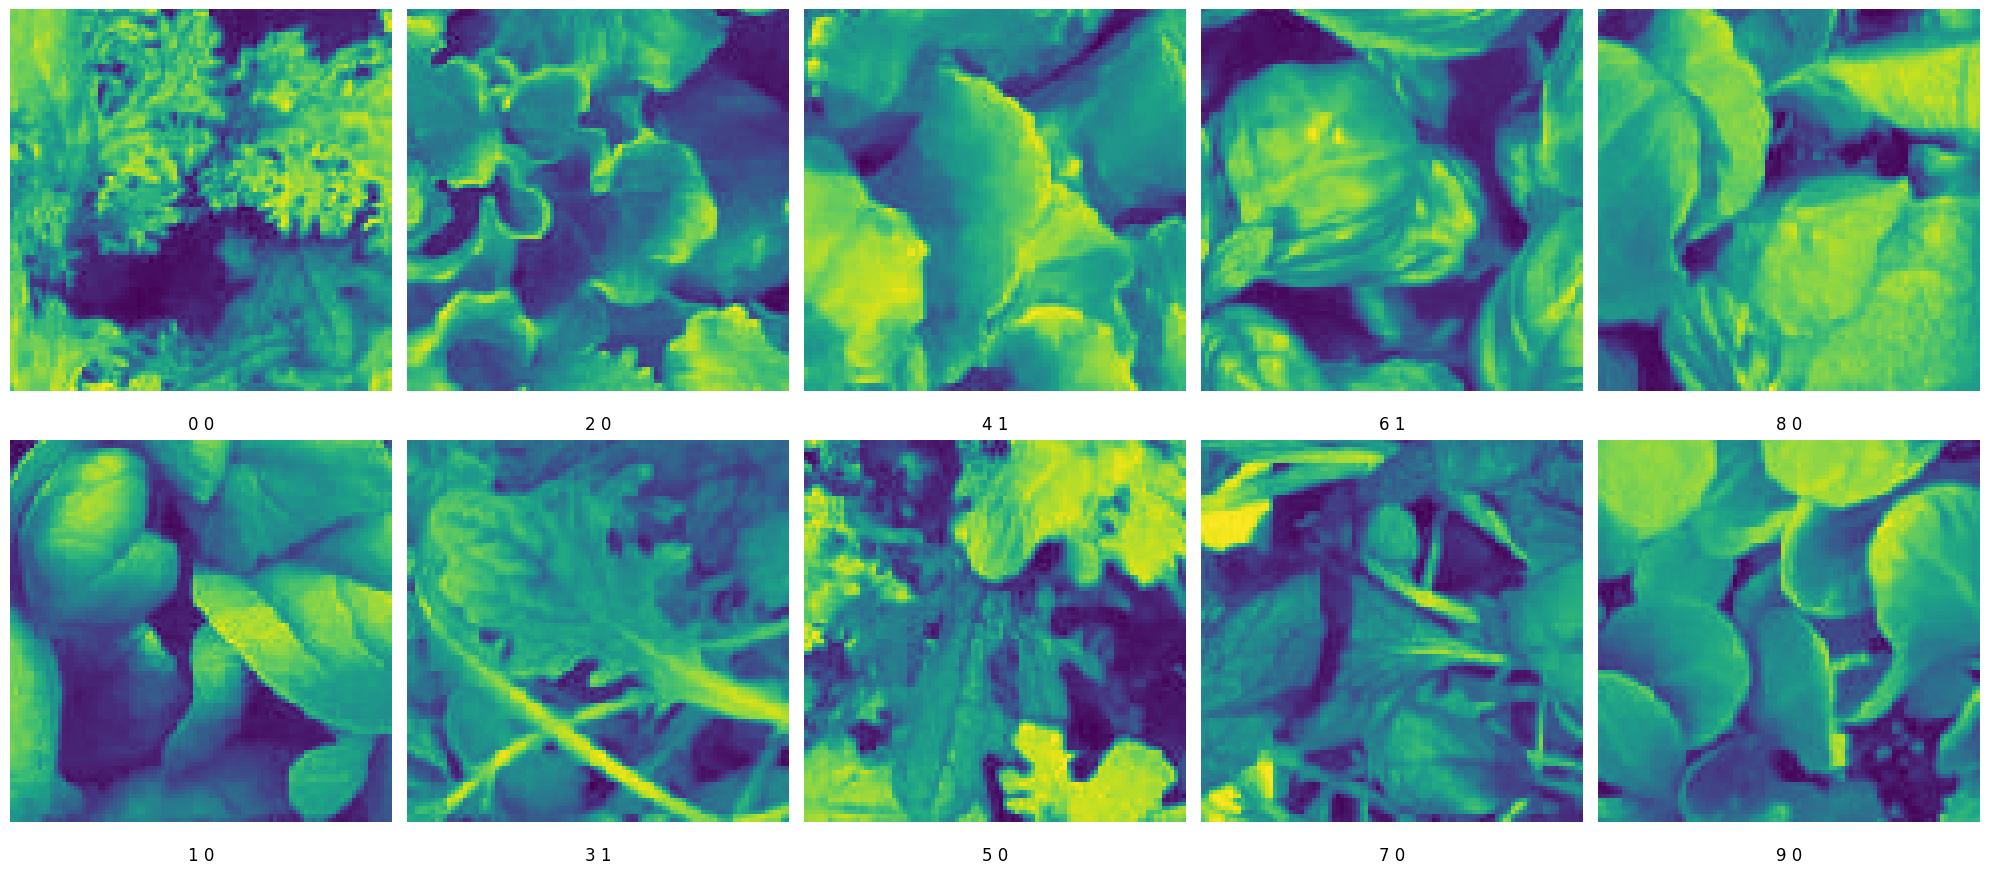

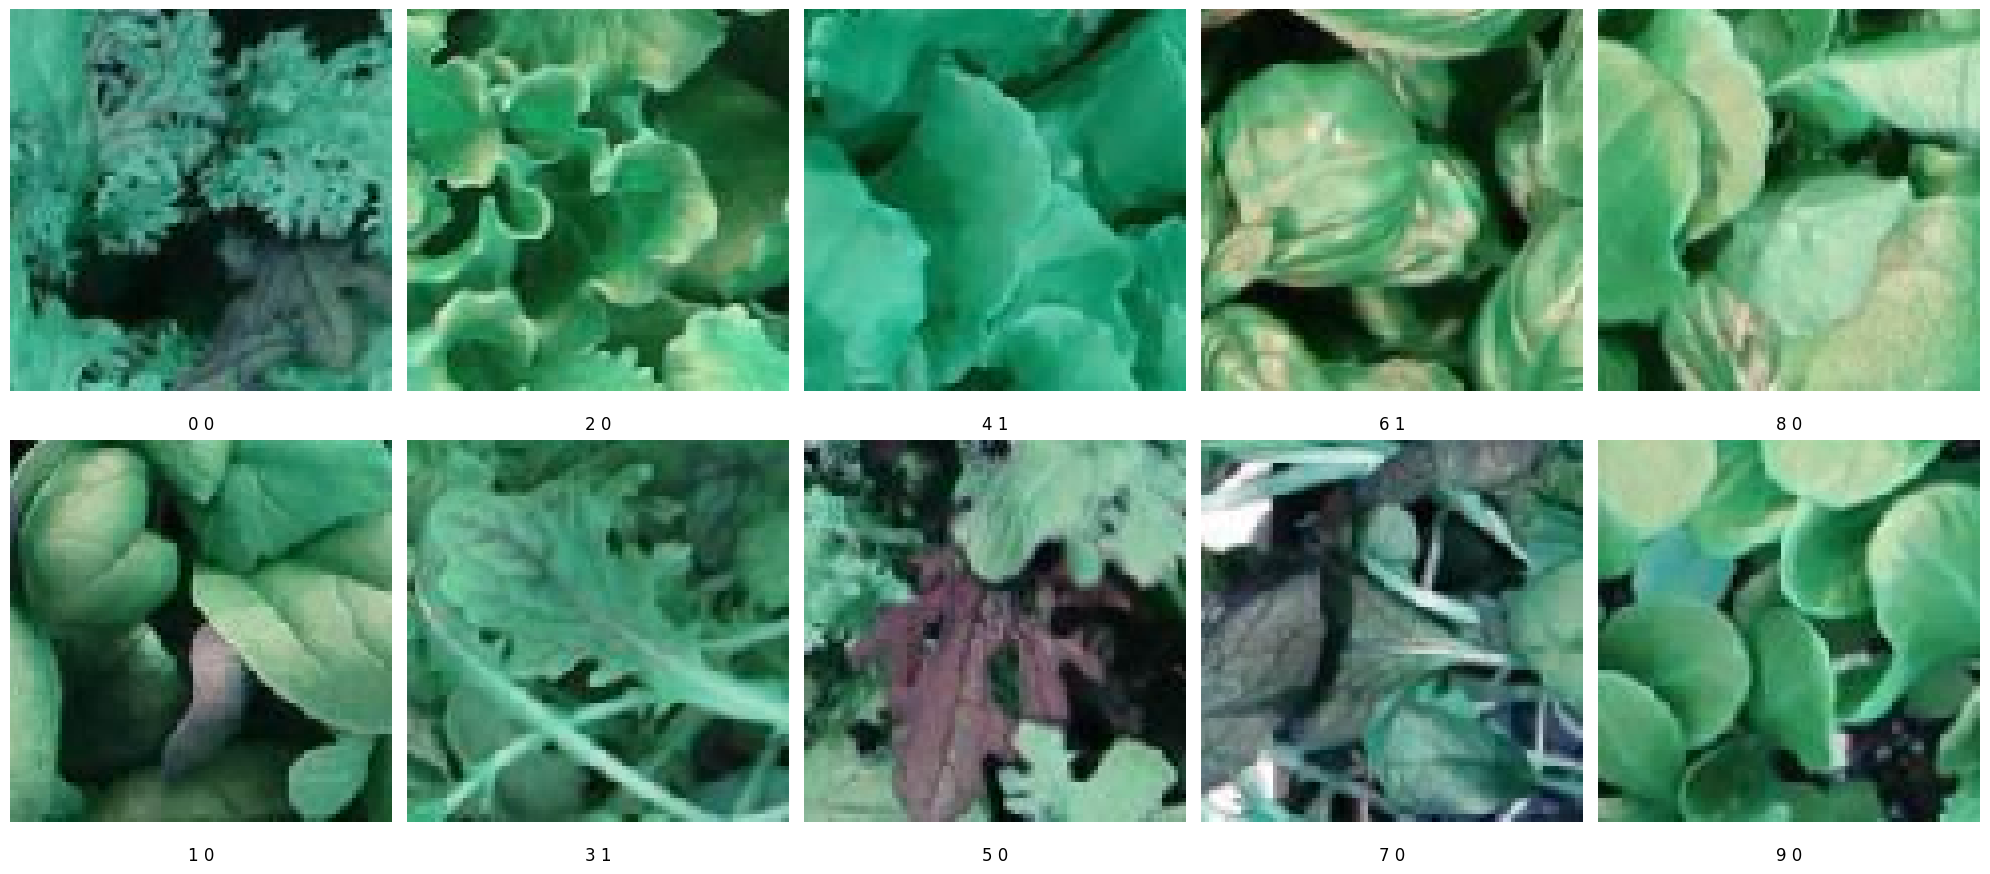

In [16]:
display_random_images(X_pretask, random=False)
display_random_images(X_train, random=False)

In [28]:
layers = [4, 6]

histories = []

for layer in layers:
  model = build_pretask_model(X_pretask.shape[1:], layer)

  history = model.fit(
        x = preprocess_input(X_pretask * 255),
        y = X_train,
        batch_size = 64,
        epochs = 200,
        validation_data = (preprocess_input(X_val_pretask * 255), X_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
  ).history

  histories.append(history)



KerasTensor(type_spec=TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), name='global_average_pooling2d_4/Mean:0', description="created by layer 'global_average_pooling2d_4'")


ValueError: ignored

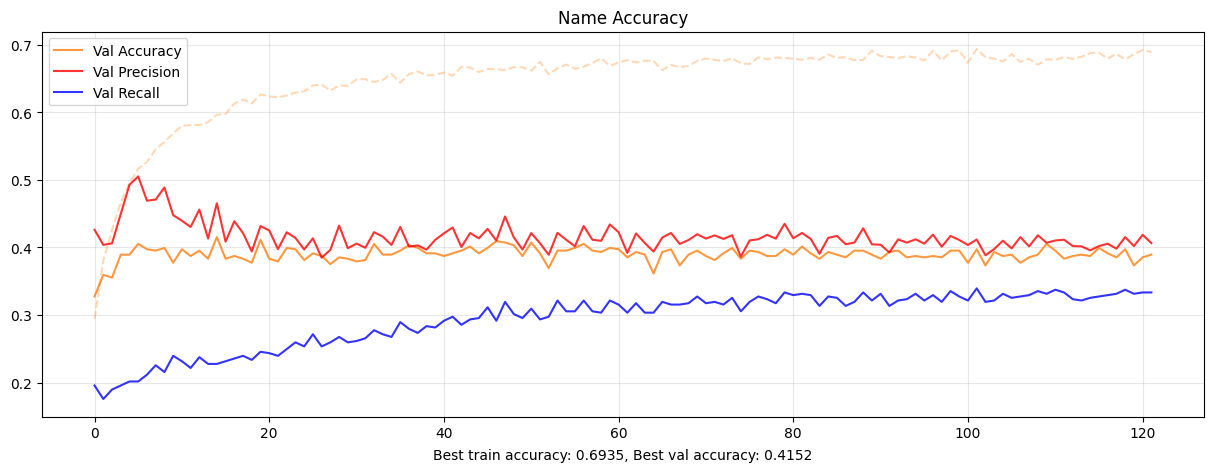

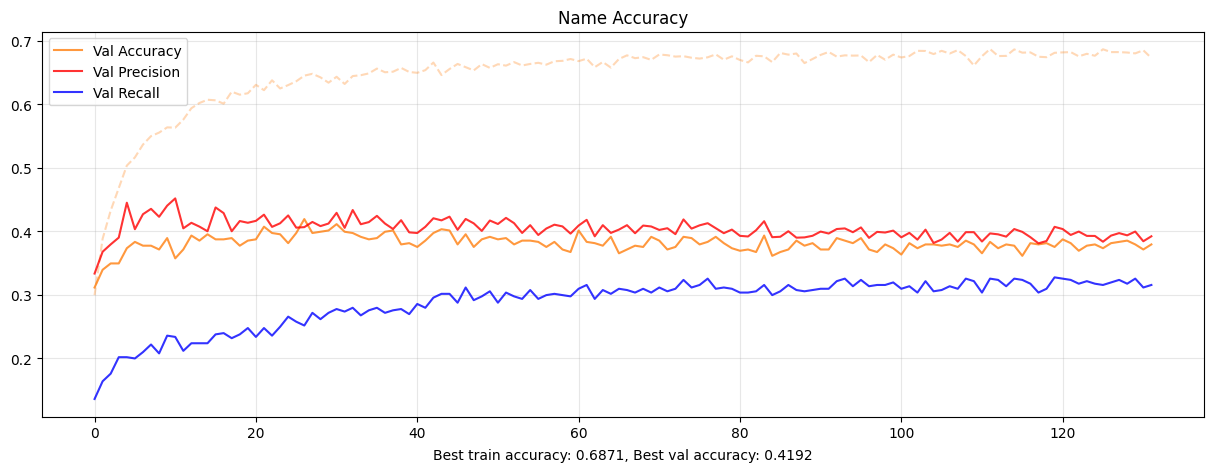

In [11]:
for history in histories:
    plot_history(history, "Name")

### Model Building

In [5]:
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)
tf.compat.v1.set_random_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

def get_block(x, neurons, batch_normalization=False, dropout=0):
    x = tfkl.Dense(neurons)(x)
    if (batch_normalization):
      x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    x = tfkl.Dropout(dropout)(x)
    return x

def build_model(input_shape, augmentation=tf.keras.Sequential([]), name="TransferModel", dropout=0.5, batch_normalization=True, learning_rate=1e-4, weight_decay=0, neurons=[]):
    mobile = tfk.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        pooling='avg',
    )

    mobile.trainable = False

    inputs = tfk.Input(shape=input_shape)

    inputs = augmentation(inputs)

    # Connect MobileNetV2 to the input
    x = mobile(inputs)

    for n in neurons:
      x = get_block(x, n, batch_normalization=batch_normalization, dropout=dropout)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    outputs = tfkl.Dense(1, activation='sigmoid')(x)

    # Create a Model connecting input and output
    model = tfk.Model(inputs=inputs, outputs=outputs, name=name)

    print(model.summary())

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate, weight_decay=weight_decay), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

    return model

### Validation and comparison

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      #tfkl.RandomFlip("horizontal_and_vertical"),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      #tf.keras.layers.RandomBrightness(0.3, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomBrightness(0.2, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
    tfkl.RandomFlip(),
    tfkl.RandomTranslation(height_factor = (-0.5,0.5), width_factor = (-0.5,0.5), fill_mode = 'reflect'),
    tfkl.RandomZoom(0.2, fill_mode = 'reflect'),
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomRotation((-1,1), fill_mode = 'reflect'),
])
]

models = [
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[0]),
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[2]),
]

batch_size = 64

weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

class_weights = {
    0: weights[0],
    1: weights[1]
}

histories = []

for i, batch in enumerate(models):
  histories.append(
      models[i].fit(
        x = preprocess_input(X_train * 255),
        y = y_train,
        batch_size = batch_size,
        epochs = 200,
        class_weight = class_weights,
        validation_data = (preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True, start_from_epoch=10),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
      ).history
  )

16/16 [==============================] - 0s 22ms/step
0.8253251140010134
58


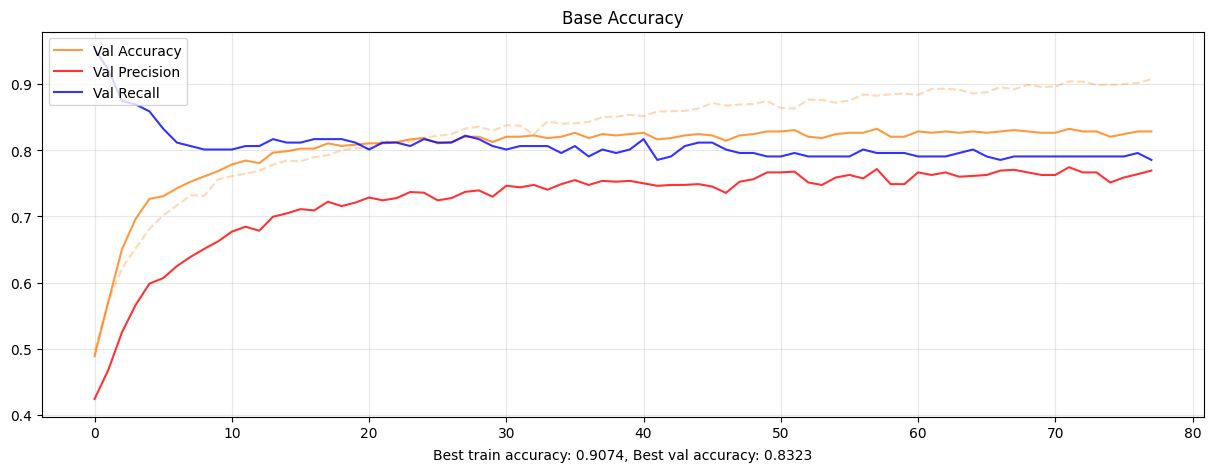

16/16 [==============================] - 0s 26ms/step
0.8168637054551596
55


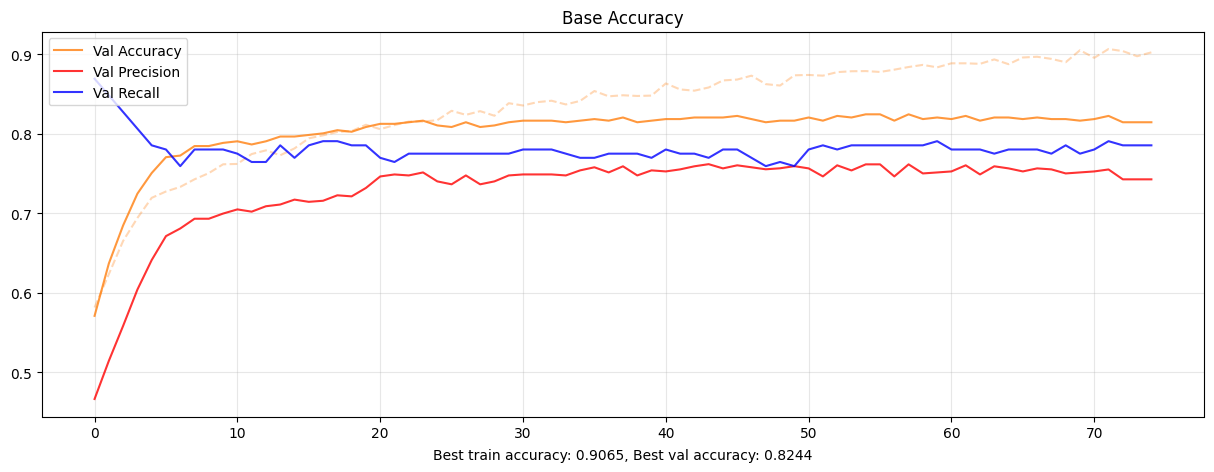

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


for i, history in enumerate(histories):
  predictions = models[i].predict(preprocess_input(X_val * 255))
  predictions = (predictions > 0.5).astype("int32")
  fpr, tpr, thresholds = roc_curve(y_val, predictions)
  roc_auc = auc(fpr, tpr)
  #print(classification_report(y_val, predictions))
  print(roc_auc)
  print(len(history['val_accuracy']) - 20)
  plot_history(history, models[i].name)

### Crossvalidation

In [19]:
def crossvalidate(model, folds):
  # Define the number of folds for cross-validation

  # Initialize lists to store training histories, scores, and best epochs
  histories = []
  scores = []
  best_epochs = []

  initial_weights = model.get_weights()

  # Create a KFold cross-validation object
  kfold = KFold(n_splits=folds, shuffle=True, random_state=42)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):

    print("Starting training on fold num: {}".format(fold_idx+1))

    model.set_weights(initial_weights)

    # Train the model on the training data for this fold

    weights = compute_class_weight(class_weight='balanced', classes=np.unique(y[train_idx]), y=y[train_idx])

    class_weights = {
        0: weights[0],
        1: weights[1]
    }

    history = model.fit(
          x = preprocess_input(X[train_idx] * 255),
          y = y[train_idx],
          batch_size = 64,
          class_weight=class_weights,
          epochs = 200,
          validation_data=(preprocess_input(X[valid_idx] * 255), y[valid_idx]),
          callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True, start_from_epoch=10),
            tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-5, mode='max')]
    ).history


    histories.append(history)
    best_epochs.append(len(history['loss']) - 30)

  return histories, best_epochs

  # Evaluate the model on the validation data for this fold
  #score = k_model.evaluate(X_train_val.iloc[valid_idx], y_train_val.iloc[valid_idx], verbose=0)
  #scores.append(score[1])

  # Calculate the best epoch for early stopping
  # Store the training history for this fold
  #histories.append(history)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

augmentations = [
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      #tfkl.RandomFlip("horizontal_and_vertical"),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      #tf.keras.layers.RandomBrightness(0.3, value_range=(0,1)),
  ]),
  tf.keras.Sequential([
      tfkl.RandomRotation(0.5),
      tfkl.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomBrightness(0.2, value_range=(0,1)),
  ])
]


models = [
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[0]),
    build_model(X_train.shape[1:], neurons=[64], dropout=0.5, batch_normalization=True, learning_rate=5e-5, weight_decay=5e-6, name="Base", augmentation=augmentations[1]),
]

histories = []
best_epochs = []

for i, model in enumerate(models):
  h, be = crossvalidate(model, 10)
  histories.append(h)
  best_epochs.append(be)

Model: "Base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense_24 (Dense)            (None, 64)                81984     
                                                                 
 batch_normalization_12 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 64)                0         
                                                                 
 dropout_12 (Dropout)        (None, 64)                0      

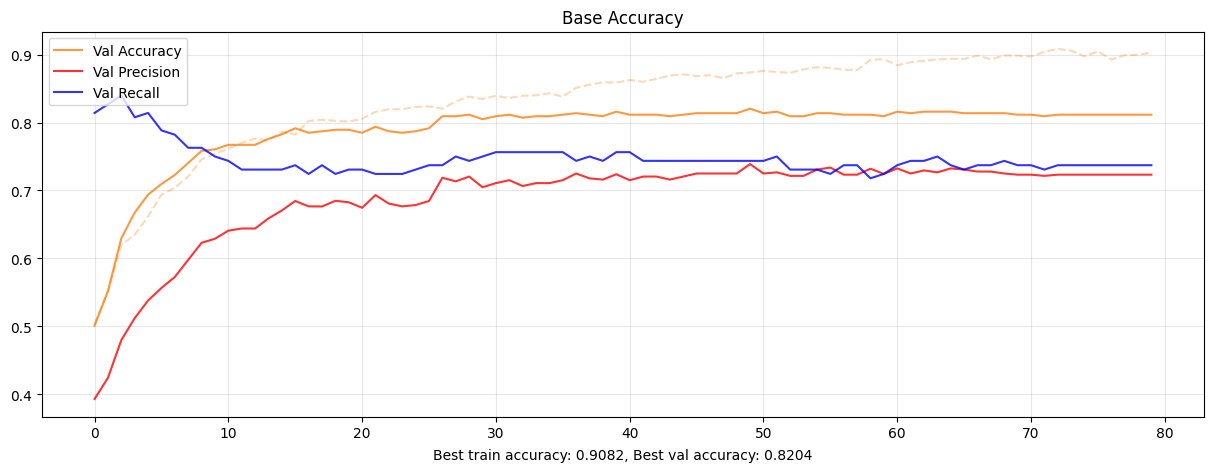

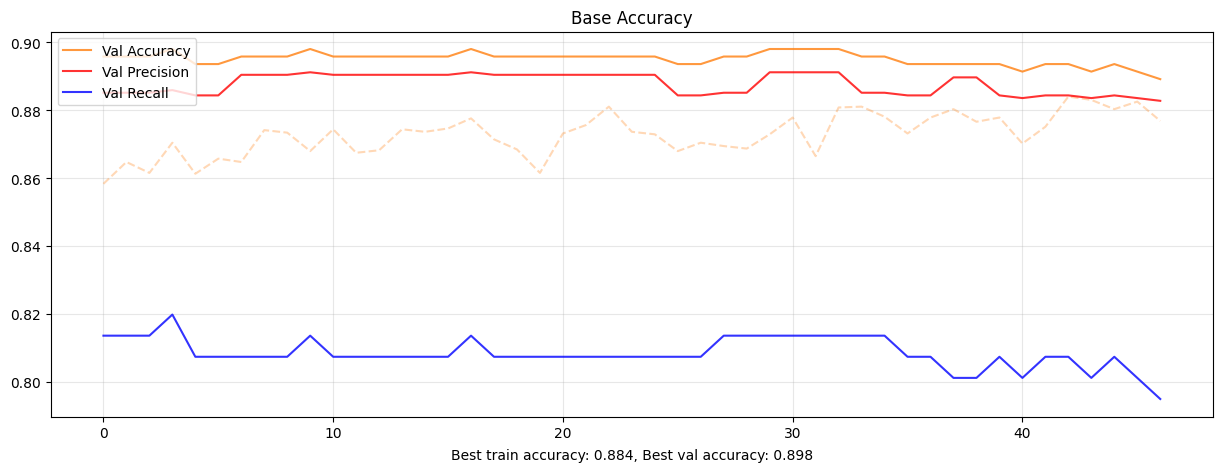

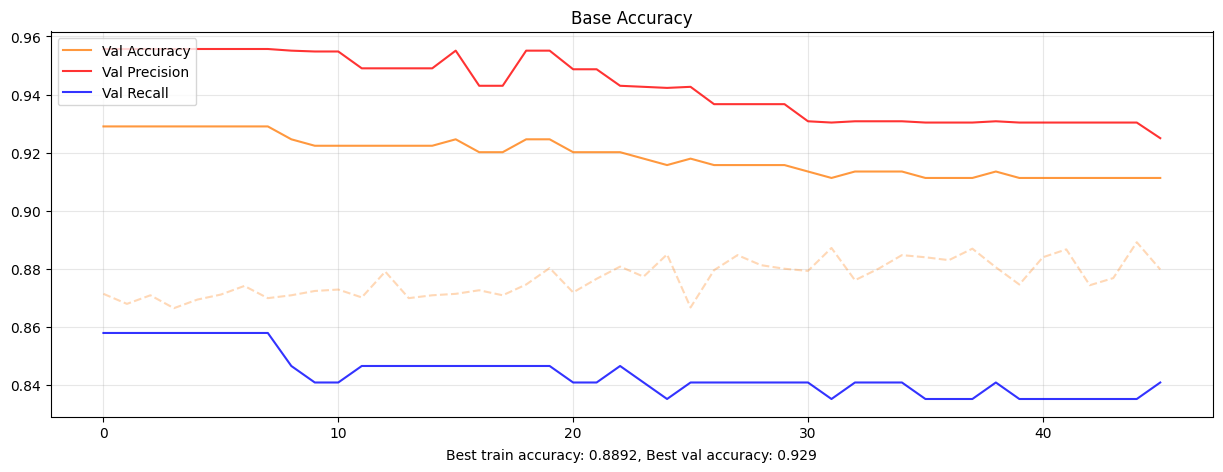

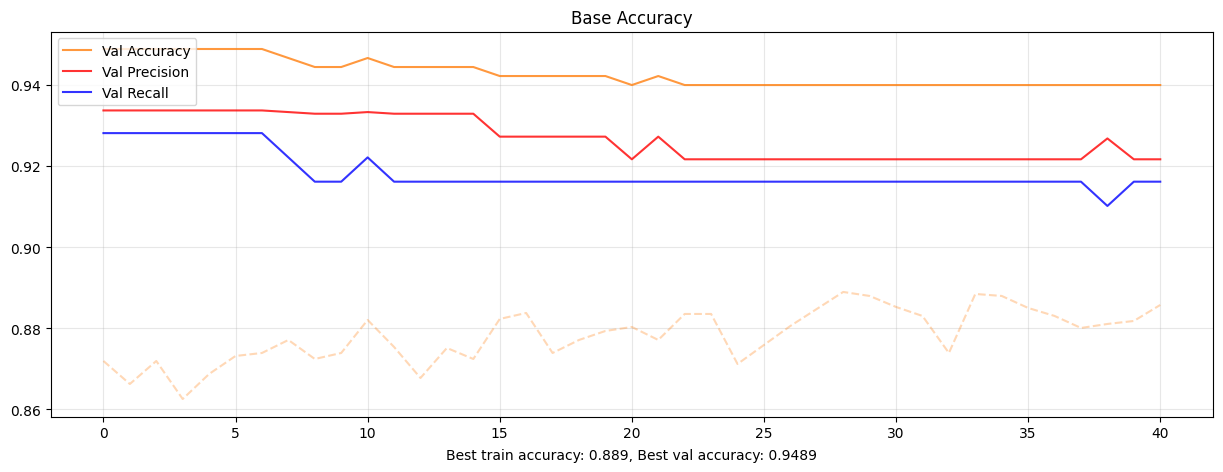

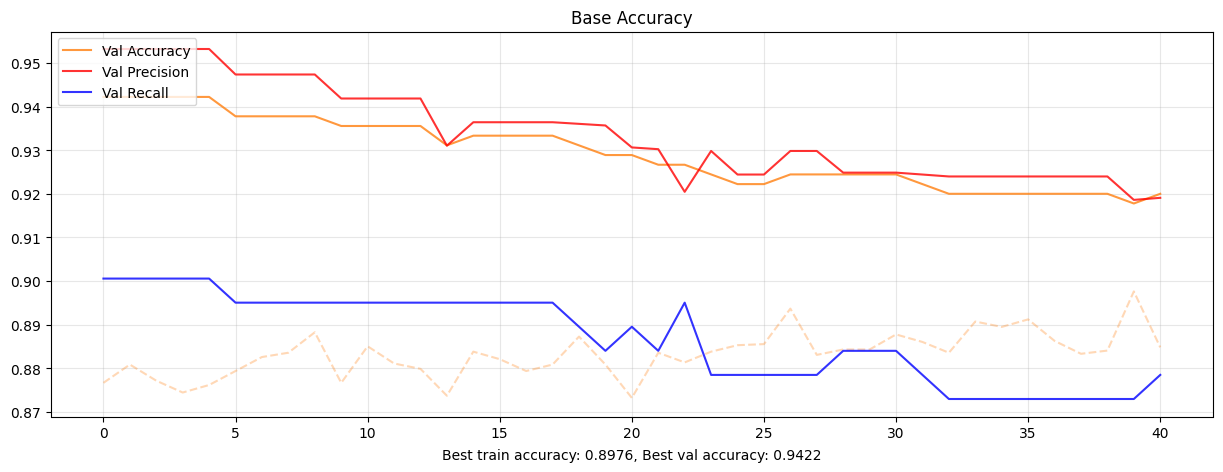

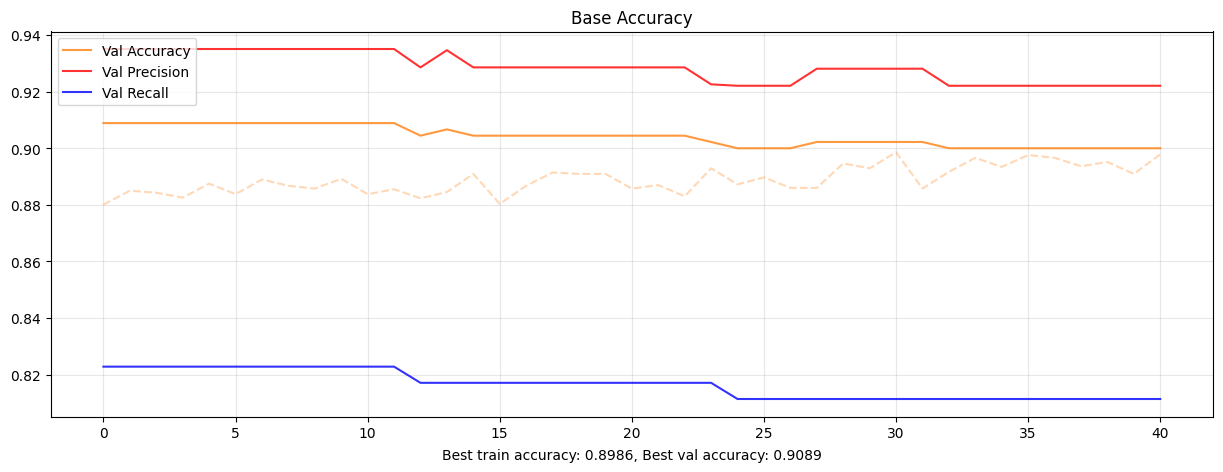

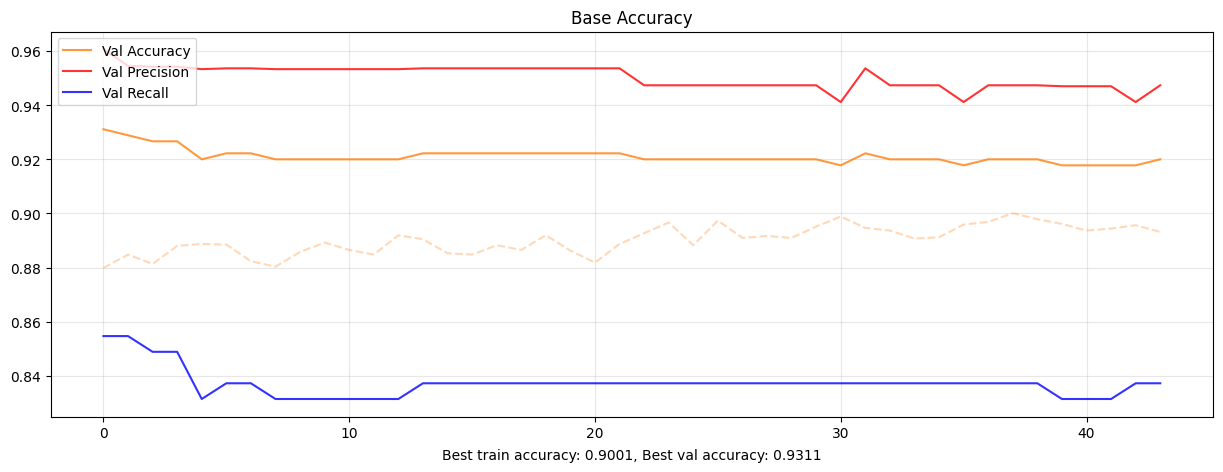

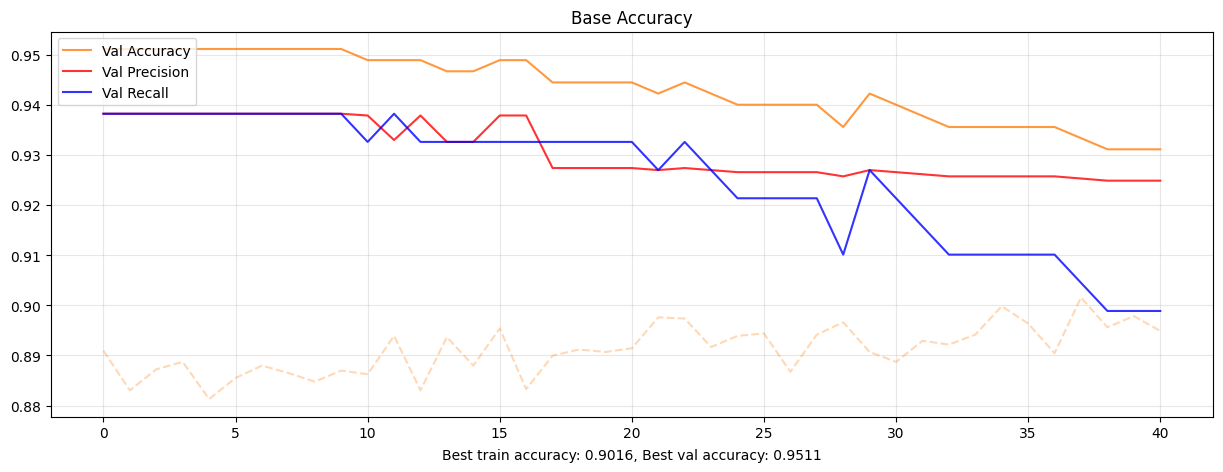

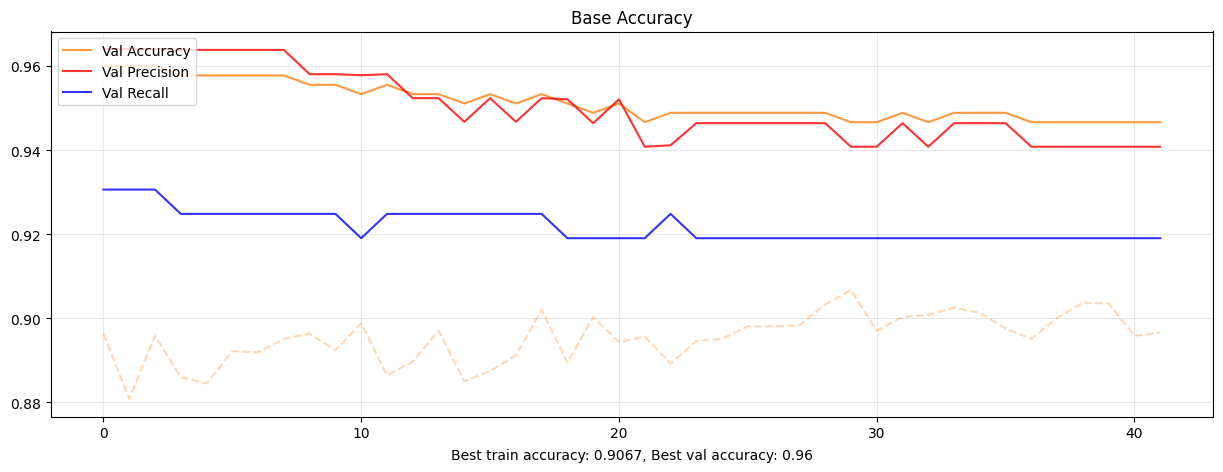

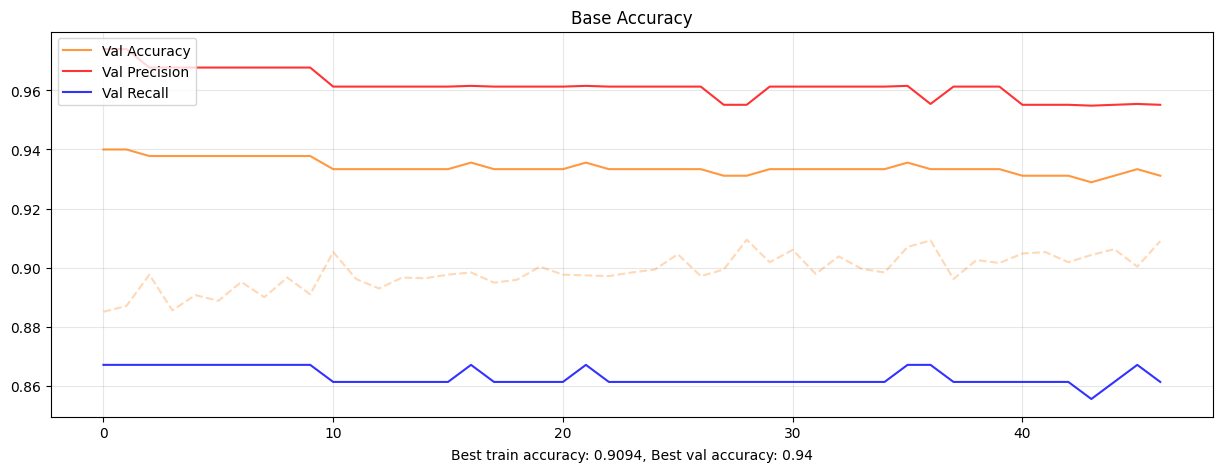

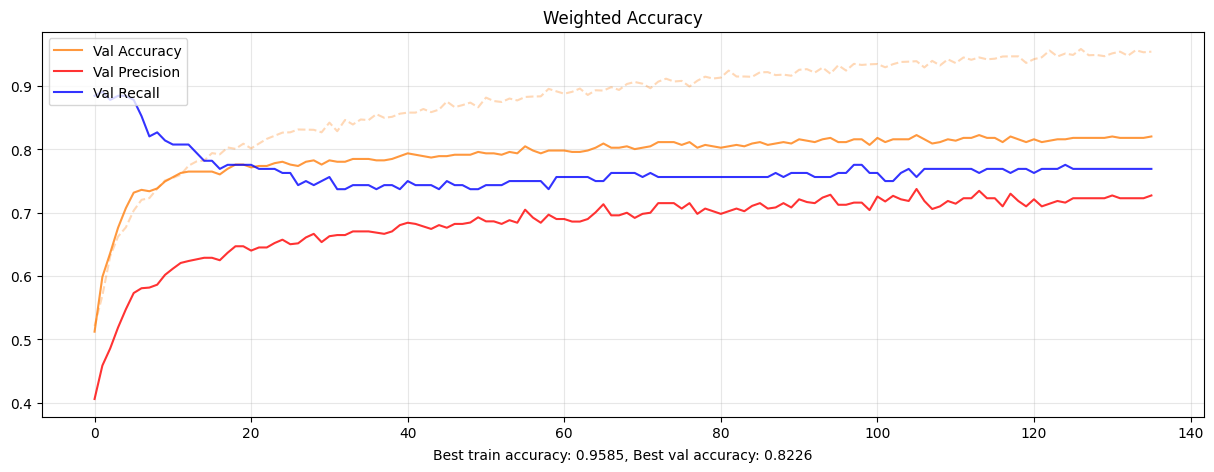

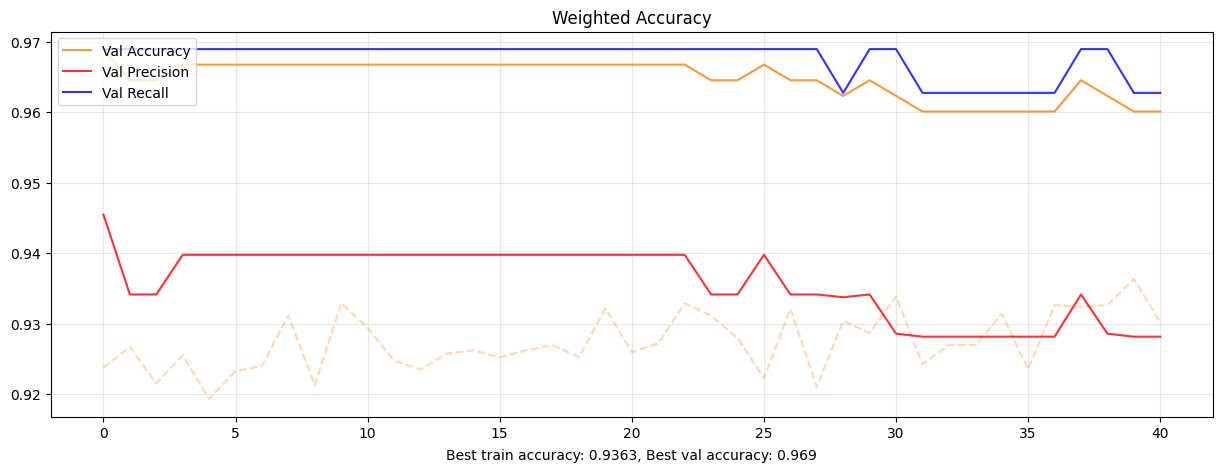

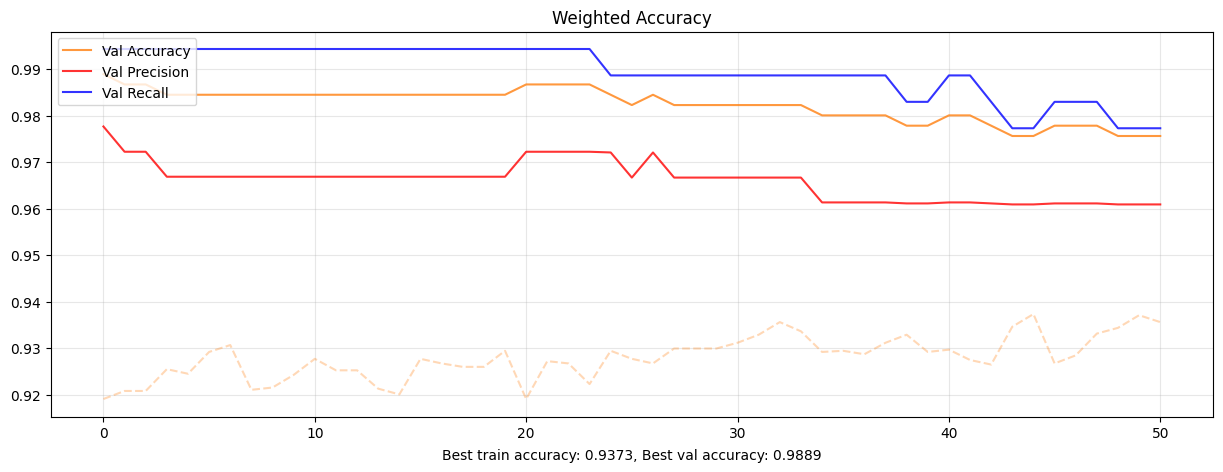

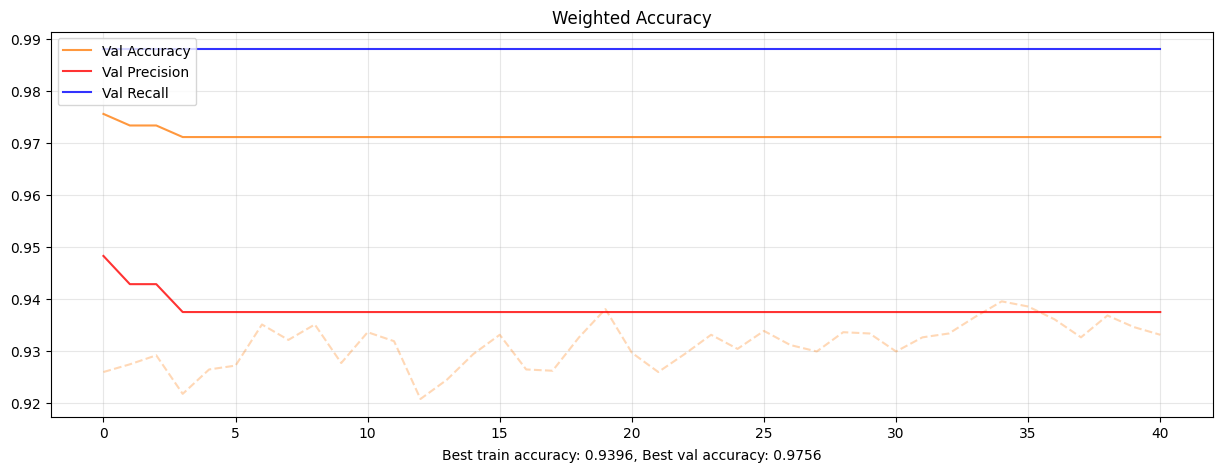

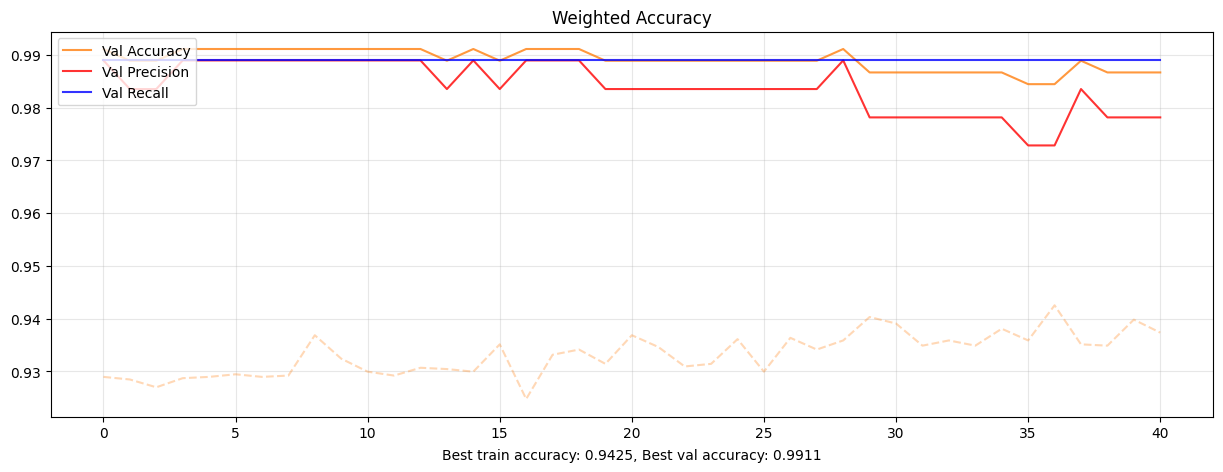

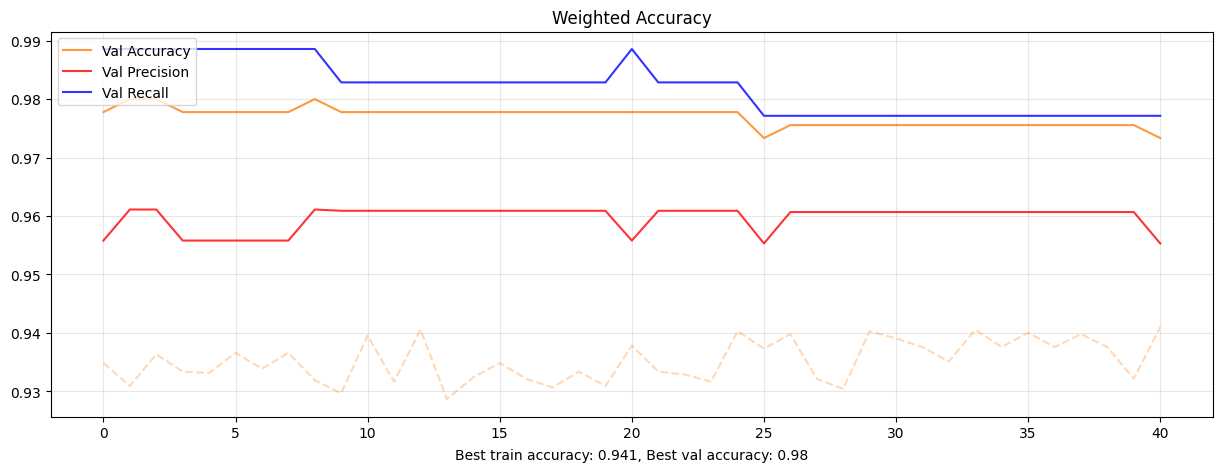

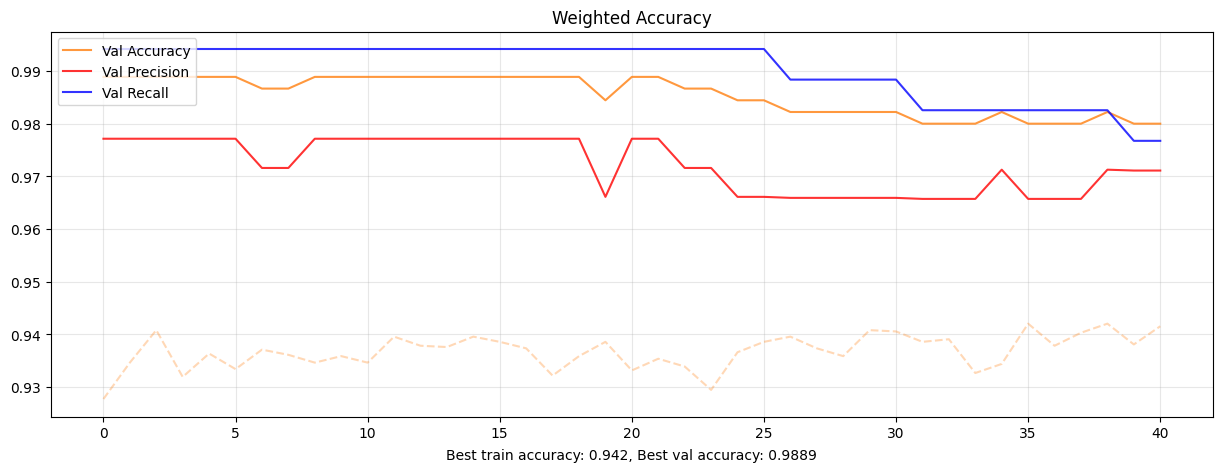

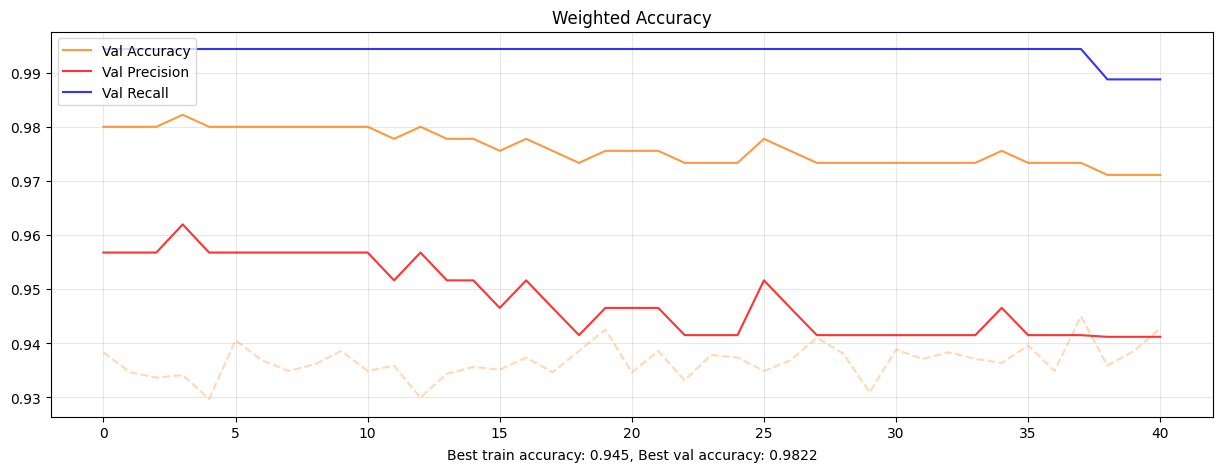

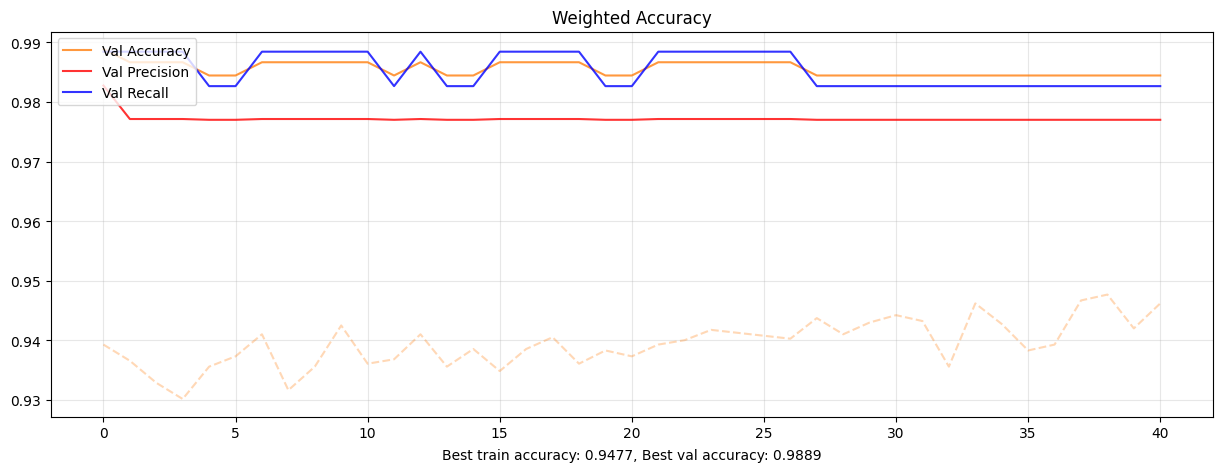

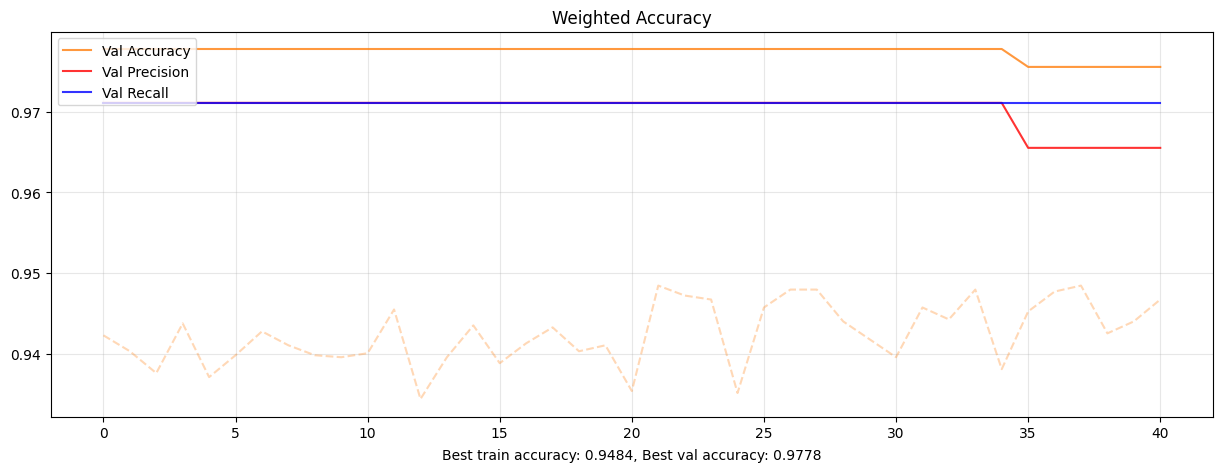

In [ ]:
for history in histories[0]:
  plot_history(history, "Base")
for history in histories[1]:
  plot_history(history, "Weighted")

### Fine Tuning

In [ ]:
!rm -rf TransferLearningModel

In [ ]:
model = models[0]
model.save("TransferLearningModel")
del model

In [ ]:
def fine_tune(layers, learning_rate):
  model = tf.keras.models.load_model("TransferLearningModel")

  base_model = model.get_layer('mobilenetv2_1.00_96')

  base_model.trainable = False

  if (layers > 0):
    for i, layer in enumerate(base_model.layers[-layers:]):
      #if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True
      print(layer)

  for i in range(len(base_model.layers) - layers):
    if (base_model.layers[i].trainable):
      raise Exception("ERROR IN CONFIGURATION, FROZEN LAYERS ARE TRAINABLE")
  for i in range(len(base_model.layers) - layers, len(base_model.layers)):
    if (not base_model.layers[i].trainable and not isinstance(base_model.layers[i], tfkl.BatchNormalization)):
      raise Exception("ERROR IN CONFIGURATION, UNFROZEN LAYERS ARE NOT TRAINABLE")

  model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate), metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])

  return model

In [ ]:
histories = []

layers = [0, 4, 6]
learning_rates = [8e-6, 8e-6, 8e-6]


for i, layer in enumerate(layers):
  model = fine_tune(layer, learning_rates[i])
  histories.append(
      model.fit(
        x = preprocess_input(X_train * 255),
        y = y_train,
        class_weight={
            0: weights[0],
            1: weights[1]
        },
        batch_size = 64,
        epochs = 200,
        validation_data = (preprocess_input(X_val * 255), y_val),
        callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=60, restore_best_weights=True, start_from_epoch=5),
          tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.1, patience=20, min_lr=1e-6, mode='max')
        ]
  ).history)

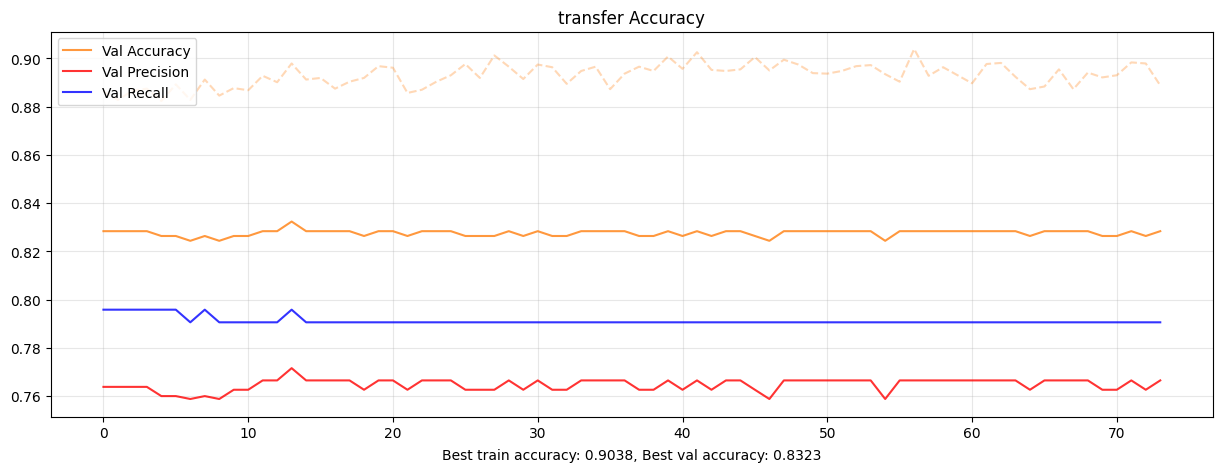

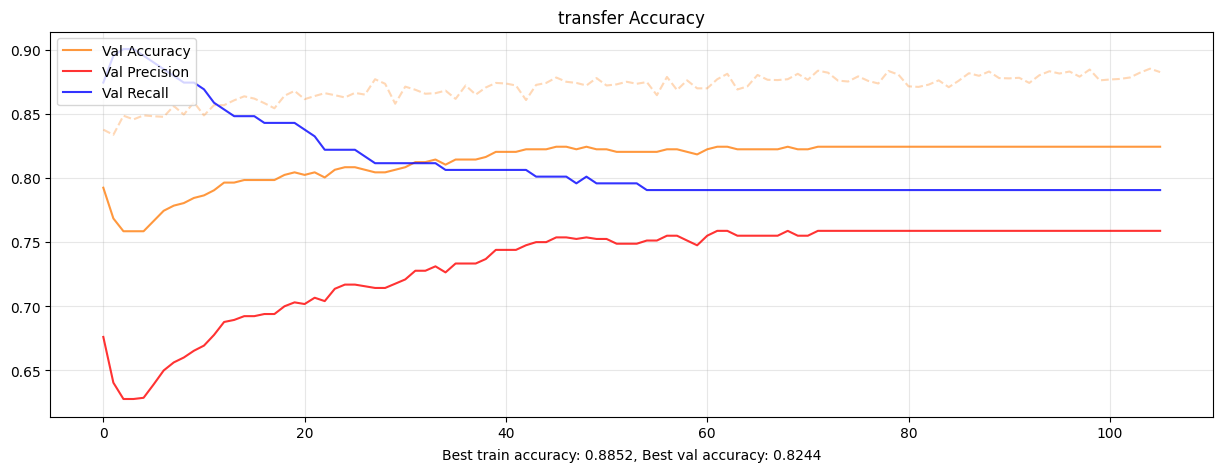

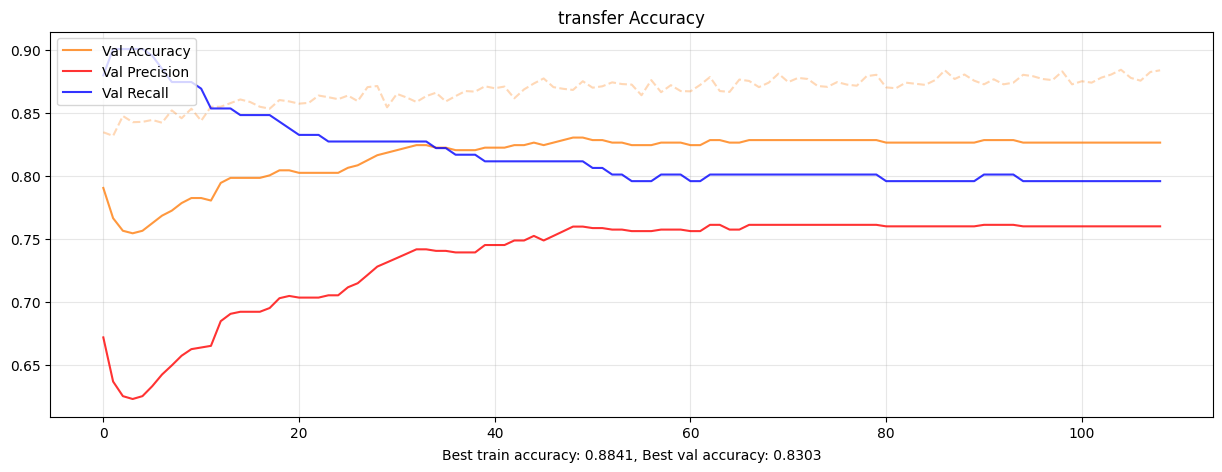

In [ ]:
for history in histories:
  plot_history(history, 'transfer')

In [ ]:
model.save("Submission")